# Identification of Deepfaked Images (and Videos?)
## By Li Run & Rongyi

This project aims to train an AI model to be able to identify deepfaked images from real ones with an accuracy of >=XX%.

## Data Collection

We utilized two datasets of images for training our model:
1. https://www.kaggle.com/datasets/manjilkarki/deepfake-and-real-images
2. https://www.kaggle.com/datasets/dagnelies/deepfake-faces

The first dataset contains approximately 70,000 training images, 5400 test images and 20,000 validation images of faces for both Real and Fake images each.

The second dataset contains approximately 95,600 images of faces. Labelling of the images as real or fake can be found under `metadata.csv`.

## Data Preprocessing

Let us first inspect the contents of `deepfake_faces`.

In [1]:
# Imports
import pandas as pd
import numpy as np
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import random
from sklearn.utils.class_weight import compute_class_weight
import os, os.path, shutil
from tqdm import tqdm
import cv2

2024-03-15 17:41:33.580128: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-15 17:41:33.580269: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-15 17:41:33.755809: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
df = pd.read_csv('/kaggle/input/deepfake-faces/metadata.csv')
df.head()

,videoname,original_width,original_height,label,original
0,aznyksihgl.mp4,129,129,FAKE,xnojggkrxt.mp4
1,gkwmalrvcj.mp4,129,129,FAKE,hqqmtxvbjj.mp4
2,lxnqzocgaq.mp4,223,217,FAKE,xjzkfqddyk.mp4
3,itsbtrrelv.mp4,186,186,FAKE,kqvepwqxfe.mp4
4,ddvgrczjno.mp4,155,155,FAKE,pluadmqqta.mp4


In [3]:
df[df.videoname == 'aaagqkcdis.mp4']

,videoname,original_width,original_height,label,original
18722,aaagqkcdis.mp4,90,89,FAKE,eklsrnkwog.mp4


We took the name of the first image `aaaqgkcdis.jpg` and looked it up in`metadata.csv`, confirming that the image names corresponded to entries within the csv file allowing us to label the images ourselves.

In [4]:
df['label'].value_counts()

label
FAKE    79341
REAL    16293
Name: count, dtype: int64

From here we can see that the Fake:Real ratio in `deepfake_faces` is about 5:1. We need to handle this class imbalance in our data, which we will do by just taking a sample of 16,000 images from each Fake and Real instead. We also needs to categorise the images since they have not been labelled in the same format as in `deepfake-and-real-images`.


In [5]:
# # NOTE: Run if output working folder is still empty

folder_path = '/kaggle/input/deepfake-faces/faces_224/'

os.makedirs('/kaggle/working/deepfake-faces/Fake', exist_ok=True)
os.makedirs('/kaggle/working/deepfake-faces/Real', exist_ok=True)   

realcount = 0
fakecount = 0
for index, row in tqdm(df.iterrows()):
    img_name = row['videoname'].split('.')[0] + '.jpg'
    old_path = folder_path + img_name
    if row['label'] == 'REAL':
        if realcount < 16000:
            new_path = os.path.join('/kaggle/working/deepfake-faces/Real', img_name)
            realcount += 1
        else:
            continue

    else:
        if fakecount < 16000:
            new_path = os.path.join('/kaggle/working/deepfake-faces/Fake', img_name)
            fakecount += 1
        else:
            continue
    
    shutil.copy(old_path, new_path)

    
print("Categorisation complete")
        

95634it [03:50, 415.30it/s] 

Categorisation complete


Let us test if our categorisation worked.

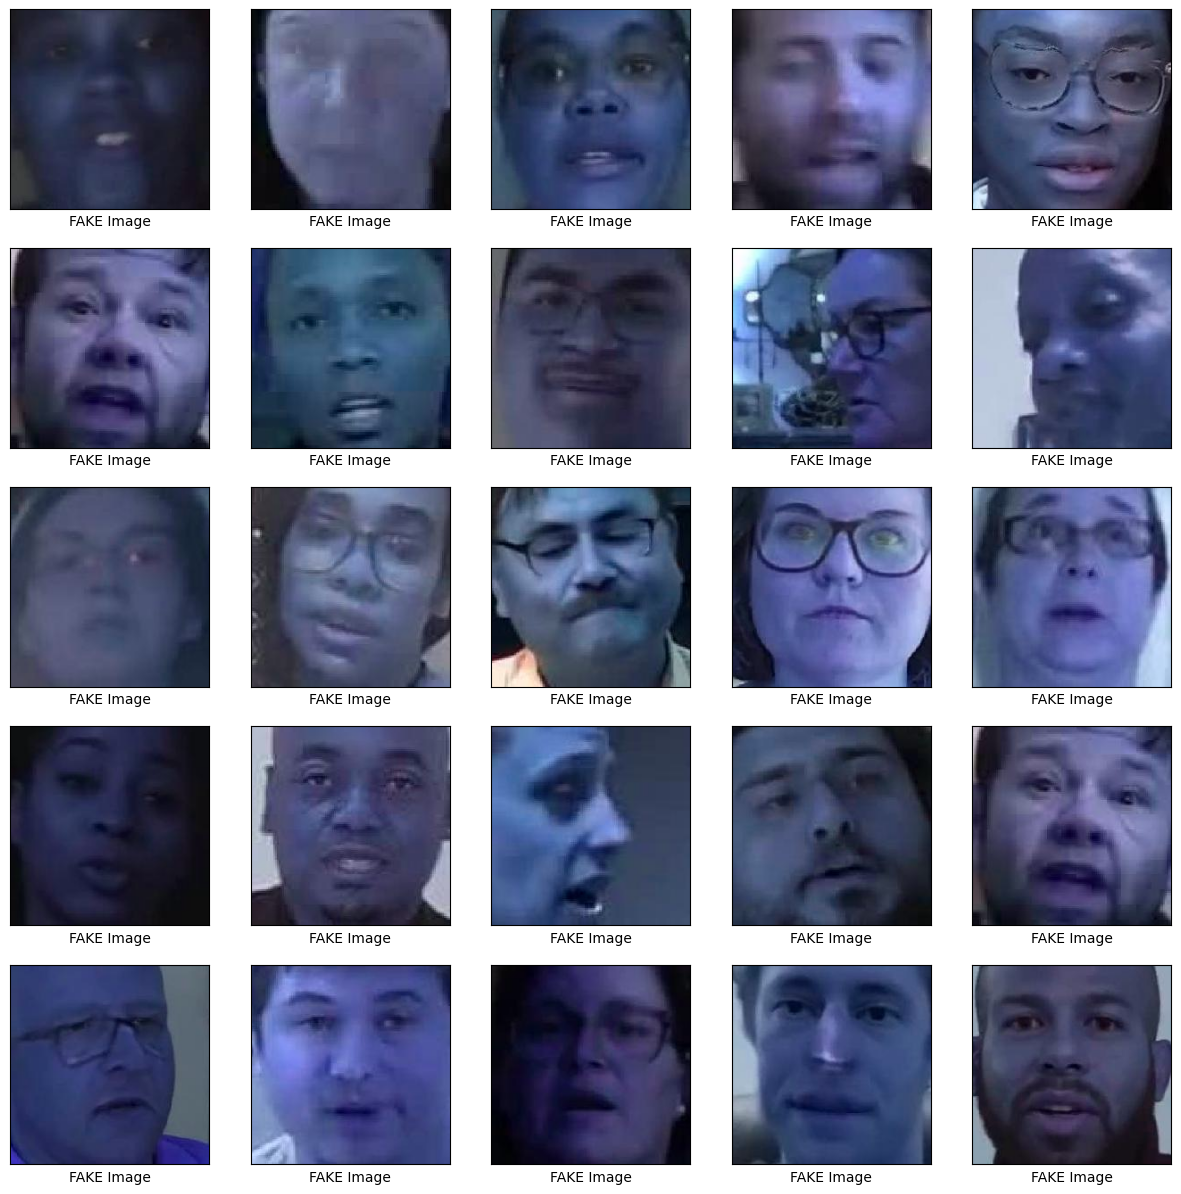

In [6]:
plt.figure(figsize=(15,15))
file_names = os.listdir('/kaggle/working/deepfake-faces/Fake/')
for i in range(25):
    idx = random.randint(0, len(file_names)) #take a random batch out of all the fake images
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    
    video_name = file_names[idx][:-4] + '.mp4'
    plt.imshow(cv2.imread('/kaggle/working/deepfake-faces/Fake/'+ file_names[idx]))
    # Redundant but i want to test if any real images made it in by some miracle
    if(df[df.videoname == video_name].iloc[0]['label']=='FAKE'):
        plt.xlabel('FAKE Image')
    else:
        plt.xlabel('REAL Image')
        
plt.show()

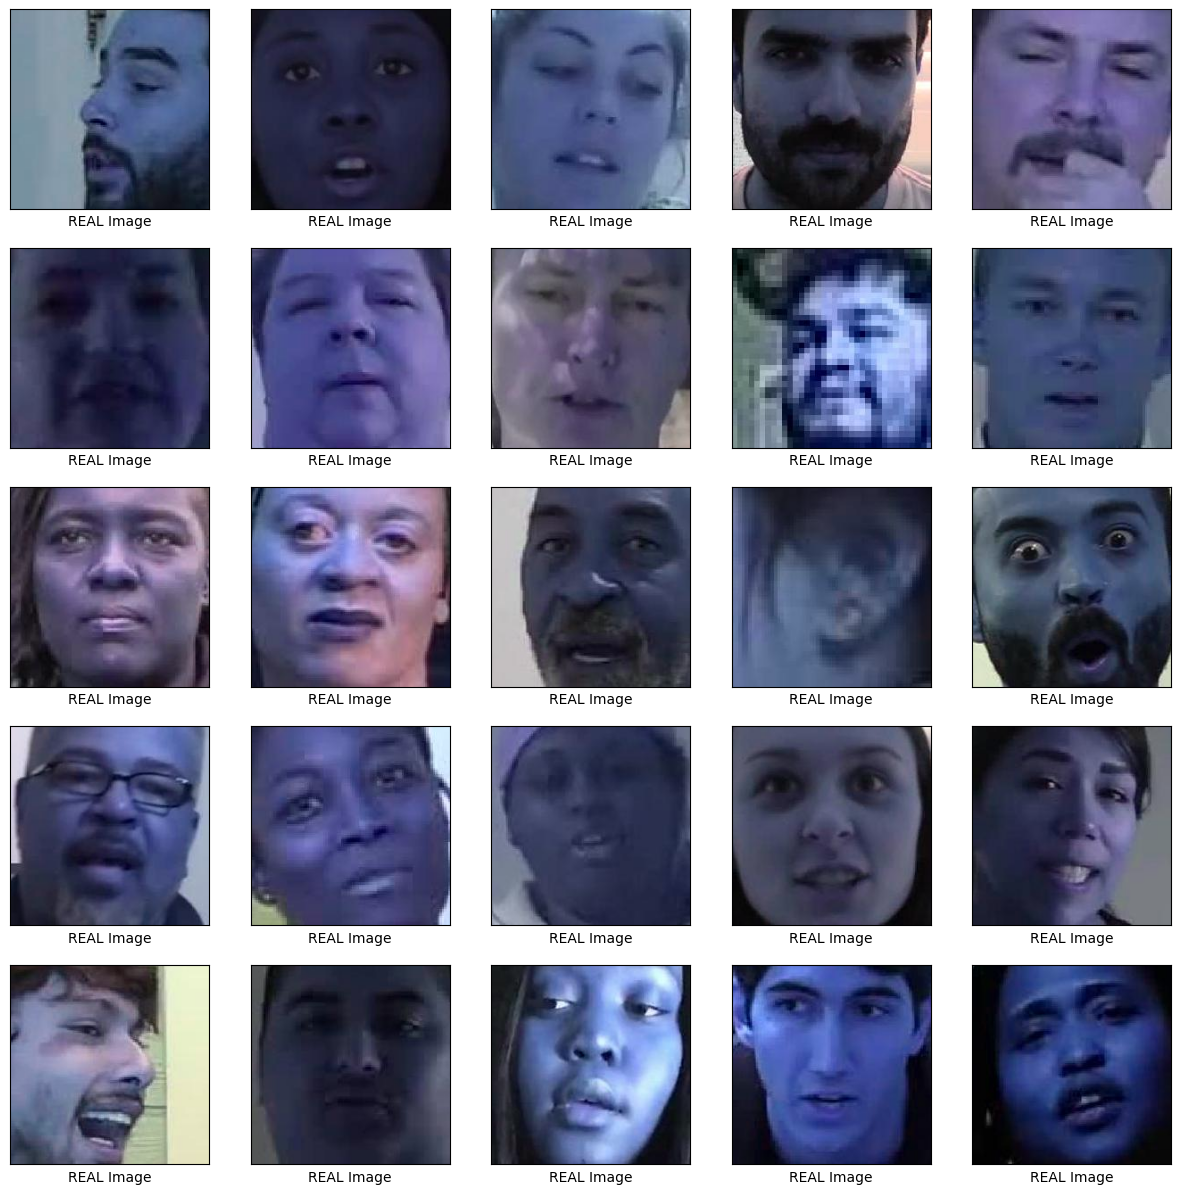

In [7]:
plt.figure(figsize=(15,15))
file_names = os.listdir('/kaggle/working/deepfake-faces/Real/')
for i in range(25):
    idx = random.randint(0, len(file_names)) #take a random batch out of all the fake images
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    
    video_name = file_names[idx][:-4] + '.mp4'
    plt.imshow(cv2.imread('/kaggle/working/deepfake-faces/Real/'+ file_names[idx]))
    # Redundant but i want to test if any fake images made it in by some miracle
    if(df[df.videoname == video_name].iloc[0]['label']=='FAKE'):
        plt.xlabel('FAKE Image')
    else:
        plt.xlabel('REAL Image')
        
plt.show()

As we can see from above, our categorisation has worked.

Next, we will organize the data into their appropriate categories before splitting them into training and test/validation data.

This is achieved by splitting the images from `deepfake_and_real_images` into their training/validation/test sets first since those have already been organised for us, then adding on the images from `deepfake_faces`.

In [8]:
train = tf.keras.utils.image_dataset_from_directory('/kaggle/input/deepfake-and-real-images/Dataset/Train', labels = 'inferred', image_size=(224,224),)
val = tf.keras.utils.image_dataset_from_directory('/kaggle/input/deepfake-and-real-images/Dataset/Validation', labels = 'inferred', image_size=(224,224),)
test =  tf.keras.utils.image_dataset_from_directory('/kaggle/input/deepfake-and-real-images/Dataset/Test', labels = 'inferred', image_size=(224,224),)

print(train.class_names)

Found 140002 files belonging to 2 classes.
Found 39428 files belonging to 2 classes.
Found 10905 files belonging to 2 classes.
['Fake', 'Real']


In [9]:
deepfake_faces = tf.keras.utils.image_dataset_from_directory('/kaggle/working/deepfake-faces', labels='inferred', image_size=(224,224),)

print(deepfake_faces.class_names)



Found 32000 files belonging to 2 classes.
['Fake', 'Real']


In [10]:
deepfake_faces = deepfake_faces.shuffle(10, reshuffle_each_iteration=True)

train_size = int(0.7 * len(deepfake_faces))
test_size = int(0.15 * len(deepfake_faces))
val_size = int(0.15 * len(deepfake_faces))

train2 = deepfake_faces.take(train_size)
test2 = deepfake_faces.skip(train_size)
val2 = test2.skip(val_size)
test2 = test2.take(test_size)

train_merged = train.concatenate(train2)
val_merged = val.concatenate(val2)
test_merged = test.concatenate(test2)


print(len(train_merged), len(train), len(train2))




5076 4376 700


We are now done with merging our datasets, and can move on to training our model.

## Training of Model

## Do we want to do transfer learning or try our own architecture first lol